### Dataset

In [35]:
import numpy as np
import pandas as pd
import random

In [36]:
##### DEFINE USER-FUNCTIONS #####
def f_get_Normalization(X, norm_mode):
    num_Patient, num_Feature = np.shape(X)

    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.std(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))/np.std(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.min(X[:,j]))/(np.max(X[:,j]) - np.min(X[:,j]))
    else:
        print("INPUT MODE ERROR!")

    return X

In [37]:
### MASK FUNCTIONS
'''
    fc_mask2      : To calculate LOSS_1 (log-likelihood loss)
    fc_mask3      : To calculate LOSS_2 (ranking loss)
'''
def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category].
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask

In [38]:
def import_dataset_METABRIC(norm_mode='standard'):
    in_filename1 = './sample data/METABRIC/cleaned_features_final.csv'
    in_filename2 = './sample data/METABRIC/label.csv'

    df1 = pd.read_csv(in_filename1, sep =',')
    df2 = pd.read_csv(in_filename2, sep =',')

    data  = np.asarray(df1)
    data  = f_get_Normalization(data, norm_mode)
    
    time  = np.asarray(df2[['event_time']])
    # time  = np.round(time/12.) #unit time = month
    label = np.asarray(df2[['label']])

    
    num_Category    = int(np.max(time) * 1.2)        #to have enough time-horizon
    num_Event       = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)

    x_dim           = np.shape(data)[1]

    mask1           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2)

    return DIM, DATA, MASK

In [39]:
(x_dim), (data, time, label), (mask1, mask2) = import_dataset_METABRIC(norm_mode ='standard')

In [40]:
DATA = (data, time, label)
MASK = (mask1, mask2)

In [41]:
data.shape, time.shape, label.shape, mask1.shape, mask2.shape

((1981, 79), (1981, 1), (1981, 1), (1981, 1, 11061), (1981, 11061))

### Network

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

In [43]:
x_dim = np.shape(data)[1]
_, num_Event, num_Category  = np.shape(mask1)

In [44]:
num_Event, num_Category

(1, 11061)

In [45]:
class DeepHit(nn.Module):
    def __init__(self):
        super(DeepHit, self).__init__()

        # INPUT DIMENSIONS
        self.x_dim              = x_dim
        self.num_Event          = num_Event
        self.num_Category       = num_Category

        # NETWORK HYPER-PARAMETERS
        self.h_dim              = 100   # number of nodes
        self.h_dim_CS           = 100

        self.p = 0.30

        # LAYER
        # 1 shared sub-network
        self.FC_NET = nn.Sequential(
            nn.Linear(self.x_dim, self.h_dim),
            nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(self.h_dim, self.x_dim),
            nn.ReLU(),
            nn.Dropout(p=self.p),
        )
        # 2 cause-specific sub-network
        # sample data Num_Event=1
        self.Cause_NET_1 = nn.Sequential(
            nn.Linear(self.x_dim + self.x_dim, self.h_dim_CS),
            nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(self.h_dim_CS, self.h_dim_CS),
            nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(self.h_dim_CS, self.h_dim_CS),
            nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(self.h_dim_CS, self.h_dim_CS),
            nn.ReLU(),
            nn.Dropout(p=self.p),
        )
        # 3 output layer
        self.o_layer = nn.Sequential(
            nn.Linear(self.num_Event*self.h_dim_CS, self.num_Event*self.num_Category),
            nn.Softmax(dim=1)
        )

    def forward(self, x):

        # FCNETS
        shared_out = self.FC_NET(x)
        last_x = x  # for residual connection
        h = torch.concat([shared_out, last_x], axis=1)

        # CSNETS
        out = []
        cs_out = self.Cause_NET_1(h)
        out.append(cs_out)

        out = torch.stack(out, axis=1) # stack referenced on subject
        out = out.reshape(-1, self.num_Event*self.h_dim_CS)

        # OUTPUT layers
        out = self.o_layer(out)
        out = out.reshape(-1, self.num_Event, self.num_Category)

        return out

### Loss

In [46]:
_EPSILON = 1e-08

##### USER-DEFINED FUNCTIONS
def log(x):
    return torch.log(x + _EPSILON)

In [47]:
### LOSS-FUNCTION 1 -- Log-likelihood loss
def loss_Log_Likelihood(out, k, fc_mask1):
    I_1 = torch.sign(k)

    #for uncensored: log P(T=t,K=k|x)
    tmp1 = torch.sum(torch.sum(fc_mask1 * out, dim=2), dim=1, keepdims=True)
    tmp1 = I_1 * log(tmp1)

    #for censored: log \sum P(T>t|x)
    tmp2 = torch.sum(torch.sum(fc_mask1 * out, dim=2), dim=1, keepdims=True)
    tmp2 = (1. - I_1) * log(tmp2)

    return - torch.mean(tmp1 + tmp2)

In [48]:
### LOSS-FUNCTION 2 -- Ranking loss
def loss_Ranking(out, k, t, fc_mask2):
    sigma1 = 0.1

    eta = []
    for e in range(num_Event):
        one_vector = torch.ones_like(t)
        e = torch.tensor(e, dtype=torch.int)
        I_2 = torch.eq(k, e+1) #indicator for event
        I_2 = torch.tensor(I_2, dtype=torch.float32)
        I_2 = torch.diag(torch.squeeze(I_2))

        out_e = out[:, e:e+1, :] #각 event별로 따로 받아와서 계산
        tmp_e = out_e.reshape(-1, num_Category) #event specific joint prob.

        R = torch.matmul(tmp_e, fc_mask2.transpose(0,1)) #no need to divide by each individual dominator
        # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

        diag_R = torch.reshape(torch.diagonal(R), [-1, 1])
        R = torch.matmul(one_vector, diag_R.transpose(0,1)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
        R = R.transpose(0,1)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

        T = torch.sign(torch.matmul(one_vector, t.transpose(0,1)) - torch.matmul(t, one_vector.transpose(0,1)))
        relu = nn.ReLU()
        T = relu(T)
        # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

        T = torch.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i
        tmp_eta = torch.mean(T * torch.exp(-R/sigma1), dim=1, keepdim=True)

        eta.append(tmp_eta)

    eta = torch.stack(eta, dim=1) #stack referenced on subjects
    eta = torch.mean(eta.reshape(-1, num_Event), dim=1, keepdim=True)

    return torch.sum(eta) #sum over num_Events

### train

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_time,te_time, tr_label,te_label, 
    tr_mask1,te_mask1, tr_mask2,te_mask2)  = train_test_split(data, time, label, mask1, mask2, test_size=0.20) 


(tr_data,va_data, tr_time,va_time, tr_label,va_label, 
    tr_mask1,va_mask1, tr_mask2,va_mask2)  = train_test_split(tr_data, tr_time, tr_label, tr_mask1, tr_mask2, test_size=0.20) 

In [51]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x, y, z, a, b):
        super(CustomDataset, self).__init__()
        self.x = x
        self.y = y
        self.z = z
        self.a = a
        self.b = b

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = torch.Tensor(self.y[idx])
        z = torch.Tensor(self.z[idx])
        a = torch.Tensor(self.a[idx])
        b = torch.Tensor(self.b[idx])
        return x, y, z, a, b

In [52]:
from torch.utils.data import DataLoader

train_dataset = CustomDataset(tr_data, tr_time, tr_label, tr_mask1, tr_mask2)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(va_data, va_time, va_label, va_mask1, va_mask2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = CustomDataset(te_data, te_time, te_label, te_mask1, te_mask2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [53]:
deephit = DeepHit()

In [54]:
optimizer = optim.Adam(deephit.parameters(), lr=1e-3)

In [55]:
epochs = 50
result = []
result2 = []

for epoch in range(epochs):
    cost = 0.0
    cost2 = 0.0

    deephit.train()
    for i, (x_mb, t_mb, k_mb, m1_mb, m2_mb) in enumerate(train_dataloader):

        out = deephit(x_mb)

        loss_1 = loss_Log_Likelihood(out, k_mb, m1_mb)
        loss_2 = loss_Ranking(out, k_mb, t_mb, m2_mb)
        loss_total = loss_1 + loss_2
        #loss_total = loss_1

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        cost += loss_total 
    
    cost = cost / len(train_dataloader)
    result.append(cost.item())

    deephit.eval()
    with torch.no_grad():
        for (x_mb, t_mb, k_mb, m1_mb, m2_mb) in val_dataloader:

            out = deephit(x_mb)

            loss_1 = loss_Log_Likelihood(out, k_mb, m1_mb)
            loss_2 = loss_Ranking(out, k_mb, t_mb, m2_mb)
            loss_total = loss_1 + loss_2
            #loss_total = loss_1

            cost2 += loss_total 
            
        cost2 = cost2 / len(val_dataloader)
        result2.append(cost2.item())

    if (epoch + 1) % 3 == 0:
        # print(f"Epoch : {epoch+1:4d},  Cost Train : {cost:.3f}")
        print(f"Epoch : {epoch+1:4d},  Cost Train : {cost:.3f},   Cost Eval : {cost2:.3f}")

/var/folders/1f/lx43cfz945zd15kk2phzq2m40000gn/T/ipykernel_3659/3324615091.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_2 = torch.tensor(I_2, dtype=torch.float32)


Epoch :    3,  Cost Train : 11.884,   Cost Eval : 12.771
Epoch :    6,  Cost Train : 10.858,   Cost Eval : 12.980
Epoch :    9,  Cost Train : 10.125,   Cost Eval : 13.366
Epoch :   12,  Cost Train : 9.605,   Cost Eval : 14.495
Epoch :   15,  Cost Train : 9.243,   Cost Eval : 15.059
Epoch :   18,  Cost Train : 9.263,   Cost Eval : 16.034
Epoch :   21,  Cost Train : 8.382,   Cost Eval : 19.601
Epoch :   24,  Cost Train : 8.388,   Cost Eval : 17.699
Epoch :   27,  Cost Train : 7.910,   Cost Eval : 22.072
Epoch :   30,  Cost Train : 7.845,   Cost Eval : 22.704
Epoch :   33,  Cost Train : 7.479,   Cost Eval : 25.737
Epoch :   36,  Cost Train : 7.747,   Cost Eval : 21.693
Epoch :   39,  Cost Train : 7.631,   Cost Eval : 21.215
Epoch :   42,  Cost Train : 7.588,   Cost Eval : 18.454
Epoch :   45,  Cost Train : 7.345,   Cost Eval : 21.664
Epoch :   48,  Cost Train : 6.938,   Cost Eval : 30.872


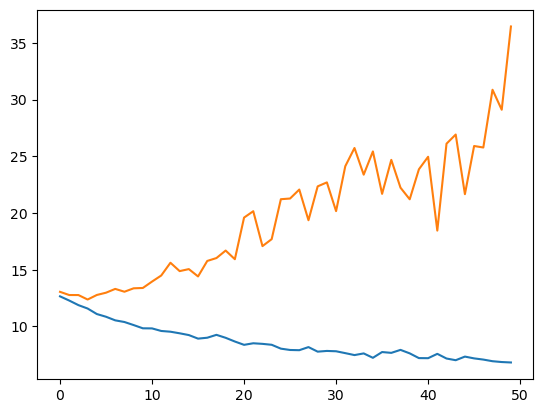

In [56]:
import matplotlib.pyplot as plt

plt.plot(result)
plt.plot(result2)
plt.show()

=> OVERFITTING !!!

- batchnorm 
- dropout
- weightdecay
- init.xavier_normal_

### eval

In [57]:
from lifelines import KaplanMeierFitter

In [58]:
### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

In [59]:
### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))

In [60]:
##### WEIGHTED C-INDEX & BRIER-SCORE
def CensoringProb(Y, T):

    T = T.reshape([-1]) # (N,) - np array
    Y = Y.reshape([-1]) # (N,) - np array

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=(Y==0).astype(int))  # censoring prob = survival probability of event "censoring"
    G = np.asarray(kmf.survival_function_.reset_index()).transpose()
    G[1, G[1, :] == 0] = G[1, G[1, :] != 0][-1]  #fill 0 with ZoH (to prevent nan values)
    
    return G

In [89]:
### C(t)-INDEX CALCULATION: this account for the weighted average for unbaised estimation
def weighted_c_index(T_train, Y_train, Prediction, T_test, Y_test, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    G = CensoringProb(Y_train, T_train)

    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        tmp_idx = np.where(G[0,:] >= T_test[i])[0]

        if len(tmp_idx) == 0:
            W = (1./G[1, -1])**2
        else:
            W = (1./G[1, tmp_idx[0]])**2

        A[i, np.where(T_test[i] < T_test)] = 1. * W
        Q[i, np.where(Prediction[i] > Prediction)] = 1. # give weights

        if (T_test[i]<=Time and Y_test[i]==1):
            N_t[i,:] = 1.

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

In [90]:
# this account for the weighted average for unbaised estimation
def weighted_brier_score(T_train, Y_train, Prediction, T_test, Y_test, Time):
    G = CensoringProb(Y_train, T_train)
    N = len(Prediction)

    W = np.zeros(len(Y_test))
    Y_tilde = (T_test > Time).astype(float)

    for i in range(N):
        tmp_idx1 = np.where(G[0,:] >= T_test[i])[0]
        tmp_idx2 = np.where(G[0,:] >= Time)[0]

        if len(tmp_idx1) == 0:
            G1 = G[1, -1]
        else:
            G1 = G[1, tmp_idx1[0]]

        if len(tmp_idx2) == 0:
            G2 = G[1, -1]
        else:
            G2 = G[1, tmp_idx2[0]]
        W[i] = (1. - Y_tilde[i])*float(Y_test[i])/G1 + Y_tilde[i]/G2

    y_true = ((T_test <= Time) * Y_test).astype(float)

    return np.mean(W*(Y_tilde - (1.-Prediction))**2)

In [91]:
EVAL_TIMES  = [144, 288, 432]
### EVALUATION
result1, result2 = np.zeros([num_Event, len(EVAL_TIMES)]), np.zeros([num_Event, len(EVAL_TIMES)])

In [92]:
FINAL1 = np.zeros([num_Event, len(EVAL_TIMES), 1])
FINAL2 = np.zeros([num_Event, len(EVAL_TIMES), 1])

In [93]:
for t, t_time in enumerate(EVAL_TIMES):

    eval_horizon = int(t_time)

    if eval_horizon >= num_Category:
        print( 'ERROR: evaluation horizon is out of range')
        result1[:, t] = result2[:, t] = -1
    else:
        deephit.eval()
        with torch.no_grad():
            te_data = torch.Tensor(te_data)
            out = deephit(te_data)
            out = out.numpy()

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(out[:,:,:(eval_horizon+1)], axis=2) #risk score until EVAL_TIMES

            for k in range(num_Event):
                # result1[k, t] = c_index(risk[:,k], te_time, (te_label[:,0] == k+1).astype(float), eval_horizon) #-1 for no event (not comparable)
                # result2[k, t] = brier_score(risk[:,k], te_time, (te_label[:,0] == k+1).astype(float), eval_horizon) #-1 for no event (not comparable)
                result1[k, t] = weighted_c_index(tr_time, (tr_label[:,0] == k+1).astype(int), risk[:,k], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                result2[k, t] = weighted_brier_score(tr_time, (tr_label[:,0] == k+1).astype(int), risk[:,k], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)

            FINAL1[:, :, 0] = result1
            FINAL2[:, :, 0] = result2

In [94]:
print(f"C_index : {FINAL1:},  \n brier_score : {FINAL2:}")

C_index : [[[0.92740218]
  [0.80298633]
  [0.68781014]]],  
 brier_score : [[[0.01996911]
  [0.03753899]
  [0.05423271]]]
